In [115]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import pandas as pd
from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, ROC_AUC

import random
import numpy as np
torch.use_deterministic_algorithms(True)
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

# Load Dataset From Disk

In [116]:
def load_imdb_data(data_filie, size):
    df = pd.read_csv(data_filie)
    if size > 0:
        df = df[1: size]
    raw_text = df['text'].tolist()
    print(df['label'].value_counts())
    raw_text_labels = [1 if sentiment == 'design' else 0 for sentiment in df['label'].tolist()]
    return raw_text, raw_text_labels

texts, labels = load_imdb_data('./combined_raw.csv', 20)

label
design     10
general     9
Name: count, dtype: int64


In [117]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', 
                                  max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label)}



In [118]:
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 5

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer,  max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [119]:
# read sample data
train_data_iter = iter(train_dataloader)
sample_text = next(train_data_iter)

In [120]:
print(sample_text)

{'input_ids': tensor([[  101,  7815,  5227,  4863,  2725,  2242,  4132,  2170,  2930,  2170,
          9377,  2545,  4604,  7815,  5227,  3563,  4769,  2097,  7481,  2801,
          7815,  2242,  3160,  4374,  7815,  2951,  2215,  4374,  7815,  5227,
          2113,  3828,  2573,  3252,  4364,  2507,  2592,  4604,  7815,  5674,
          2699,  8556,  3606,  2113,  7815,  2573,  2478,  3642,  4025,  2147,
          3246,  2393,  4283,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

## Construct the Classifier

In [121]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits


In [122]:
if torch.backends.mps.is_available():
    device = torch.device("mps") 
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


## Define Training and Evaluation Functions

In [123]:
learning_rate = 2e-5


model = BertClassifier(bert_model_name, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)

/Users/lithe/.conda/envs/conc_stab/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [124]:
def train_step(engine, batch):
    model.train()
    
    optimizer.zero_grad()
    
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    
    labels = batch['label'].to(device)
    
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    loss = nn.CrossEntropyLoss()(outputs, labels)
    loss.backward()
    optimizer.step()
    
    return loss.item()

def evaluation_step(engine, batch):
    model.eval()
    predictions = []
    prediction_probabilities = []
    actual_labels = []
    with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            pred_probab = torch.softmax(outputs, dim=1)
            preds = torch.argmax(pred_probab, dim=1)
            
            prediction_probabilities.extend(pred_probab[:,1].cpu().tolist()) # use only predictions of positive class to compute roc_auc
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
        
    return prediction_probabilities, predictions,  actual_labels
        


    
trainer = Engine(train_step)
evaluator  = Engine(evaluation_step)

@trainer.on(Events.EPOCH_COMPLETED(every=1))
def run_validation():
    evaluator.run(val_dataloader)
    


@trainer.on(Events.EPOCH_COMPLETED(every=1))
def log_validation():
    metrics = evaluator.state.metrics
    auc_scores.append(metrics['roc_auc'])
    epochs.append(trainer.state.epoch)
    accuracy_scores.append(metrics['accuracy'])
    
    results = {
        'epoch': epochs,
        'auc_score': auc_scores,
        'accuracy_score': accuracy_scores
    }
    
    results_df = pd.DataFrame(data=results)
    results_df.to_csv(f"./results/{bert_model_name}.csv", index=False)
    
    print(f"Epoch: {trainer.state.epoch}, Accuracy: {metrics['accuracy']},  ROC_AUC: {metrics['roc_auc']}")


Accuracy(output_transform= lambda x: (x[1], x[2])).attach(evaluator, "accuracy")
ROC_AUC(output_transform=lambda x: (x[0], x[2])).attach(evaluator, "roc_auc")

In [128]:
epochs = []
auc_scores = []
accuracy_scores = []


trainer.run(train_dataloader, 4)

Epoch: 1, Accuracy: 0.25,  ROC_AUC: 0.0
Epoch: 2, Accuracy: 0.25,  ROC_AUC: 0.0
Epoch: 3, Accuracy: 0.25,  ROC_AUC: 0.0


Engine run is terminating due to exception: 


KeyboardInterrupt: 

## Results Plotting

In [126]:
import matplotlib.pyplot as plt

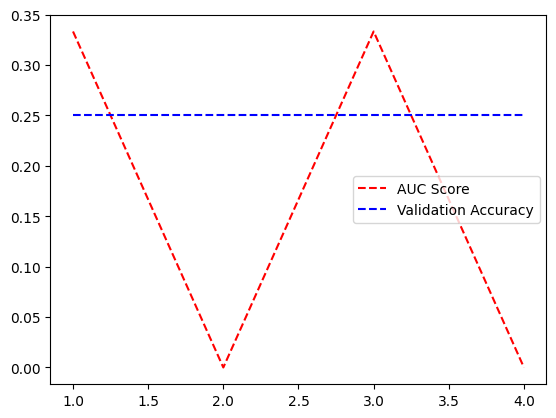

In [127]:
plt.plot(epochs, auc_scores, 'r--', epochs, accuracy_scores, 'b--')
plt.legend(['AUC Score', 'Validation Accuracy',])

## Next Steps

- check data distribution to see if you have balanced dataset
- 
- early dropping
- saving model